# Import Packages

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf                
from tqdm import tqdm
import sklearn
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
import pandas as pd


In [3]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [4]:
def load_data():
  
    
    datasets = ['../input/seg_train/seg_train', '../input/seg_test/seg_test']
    output = []
    
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [5]:
x = cv2.imread('/kaggle/input/seg_train/seg_train/mountain/14986.jpg')
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)


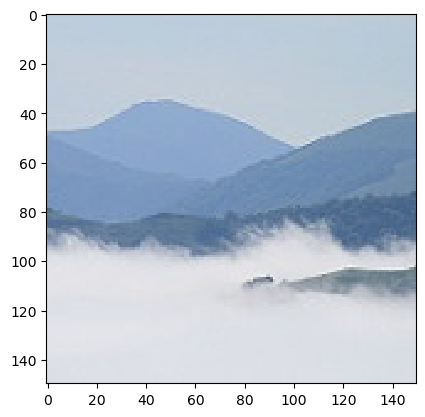

In [6]:
plt.imshow(x, interpolation='nearest')
plt.show()

In [7]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading ../input/seg_train/seg_train


100%|██████████| 2404/2404 [00:15<00:00, 152.40it/s]


Loading ../input/seg_test/seg_test


100%|██████████| 553/553 [00:03<00:00, 168.76it/s]


In [8]:
train_images, train_labels = sklearn.utils.shuffle(train_images, train_labels, random_state=25)

In [9]:
train_images = train_images[:10000]

In [10]:
train_images.shape

(10000, 150, 150, 3)

In [11]:
train_labels = train_labels[:10000]

In [12]:
test_images = test_images[:1500]
test_labels = test_labels[:1500]

In [13]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 10000
Number of testing examples: 1500
Each image is of size: (150, 150)


# Checking if the classes are balanced

Train classes

<BarContainer object of 6 artists>

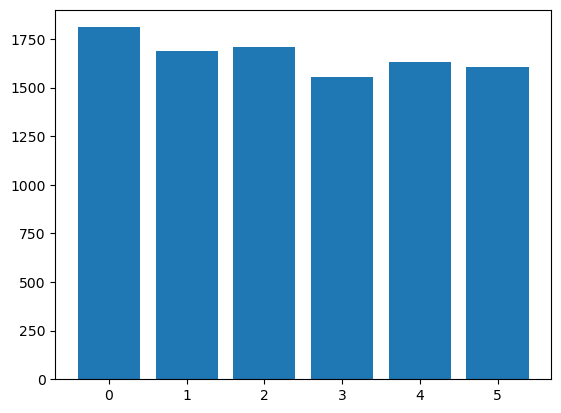

In [14]:
plt.bar(np.unique(train_labels, return_counts = True)[0], 
        np.unique(train_labels, return_counts = True)[1])

Test classes

<BarContainer object of 4 artists>

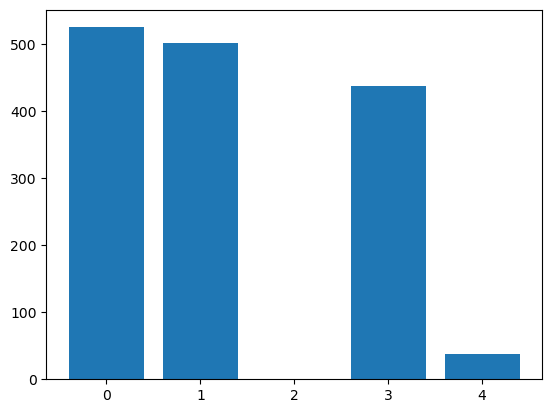

In [15]:
plt.bar(np.unique(test_labels, return_counts = True)[0], 
        np.unique(test_labels, return_counts = True)[1])

## Normalizing the data

In [16]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Viewing the images

In [17]:
index = random.randint(0, train_images.shape[0])

Text(0.5, 1.0, 'mountain')

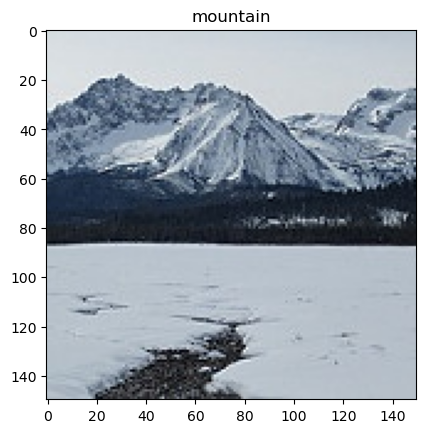

In [18]:
plt.imshow(train_images[index])
plt.title(class_names[train_labels[index]])

## Simple CNN 

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape = (150, 150, 3), activation = 'relu',
                          filters = 64, kernel_size = (3, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

In [20]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.05,
    patience=3,
)

In [21]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2,
                   callbacks = [callback])

Epoch 1/20
63/63 [==============================] - 17s 109ms/step - loss: 2.3964 - accuracy: 0.3862 - val_loss: 1.4356 - val_accuracy: 0.4385
Epoch 2/20
63/63 [==============================] - 4s 70ms/step - loss: 1.1266 - accuracy: 0.5625 - val_loss: 1.0489 - val_accuracy: 0.5995
Epoch 3/20
63/63 [==============================] - 5s 74ms/step - loss: 1.0102 - accuracy: 0.6173 - val_loss: 0.9880 - val_accuracy: 0.6220
Epoch 4/20
63/63 [==============================] - 4s 69ms/step - loss: 0.9311 - accuracy: 0.6514 - val_loss: 0.9526 - val_accuracy: 0.6340
Epoch 5/20
63/63 [==============================] - 4s 69ms/step - loss: 0.8830 - accuracy: 0.6761 - val_loss: 0.8877 - val_accuracy: 0.6705
Epoch 6/20
63/63 [==============================] - 4s 69ms/step - loss: 0.8012 - accuracy: 0.7104 - val_loss: 0.8475 - val_accuracy: 0.6905
Epoch 7/20
63/63 [==============================] - 4s 70ms/step - loss: 0.7440 - accuracy: 0.7344 - val_loss: 0.8194 - val_accuracy: 0.6970
Epoch 8/20


In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "acc")
    plt.plot(history.history['val_accuracy'], label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label = "loss")
    plt.plot(history.history['val_loss'], label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

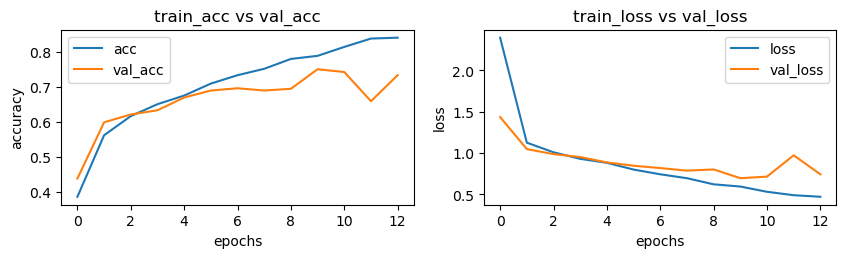

In [25]:
plot_accuracy_loss(history)

In [26]:
test_loss = model.evaluate(test_images, test_labels)

47/47 [==============================] - 1s 11ms/step - loss: 0.7795 - accuracy: 0.7347


In [27]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability




47/47 [==============================] - 1s 8ms/step


In [29]:
index = random.randint(0, test_images.shape[0])

Text(0.5, 1.0, 'Predicted street, true label is street')

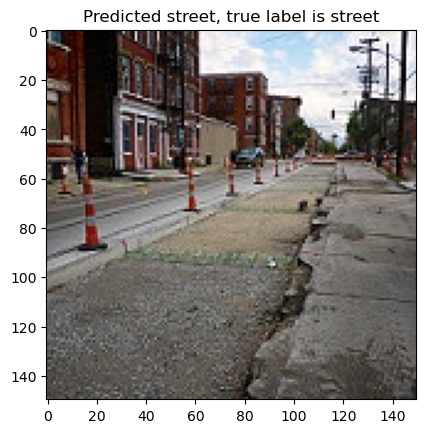

In [30]:
plt.imshow(test_images[index])
plt.title("Predicted {}, true label is {}".format(class_names[pred_labels[index]],
class_names[test_labels[index]])
)

In [31]:
sklearn.metrics.accuracy_score(test_labels, pred_labels)

0.7346666666666667